# Comparative analysis description

# Input data description

* Barbell Graph having two cliques of 20 vertices connected with a path of 5 vertices
* A cycle of 40 vertices
* A graph consisting of 5 cliques connected by random edges with density equal to 0.002 with 100 vertices in total
* A graph consisting of 7 cliques connected by random edges with density equal to 0.03 with 100 vertices in total
* A graph consisting of 7 clusters with density 0.8 connected by random edges with density equal to 0.003 with 100 vertices in total

# Computation

In [1]:
import os
os.chdir("..")
import relegy.embeddings as rle
import relegy.metrics as rlm
import relegy.graphs as rlr
os.chdir("Analysis")

In [40]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import inspect
import copy
from IPython.display import clear_output
from matplotlib.pylab import rcParams
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import sys

In [3]:
def get_embedding_methods_iterable():
    """
    Iterates over embedding methods.
    """
    return filter(lambda x: x[0][:2] != "__", inspect.getmembers(sys.modules['relegy.embeddings']))

In [57]:
def generate_clusters_graph(n, k, out_density, in_density):
    """
    Generates a random graph with k clusters which sum to n vertices. The clusters have average edge density equal to in_density
    and the remaining edges between clusters have density equal to out_density.
    Returns the graph and labels corresponding to clusters
    """
    partition = np.random.multinomial(n, np.ones(k)/k, size=1)[0]
    labels = np.repeat(np.arange(k), partition)
    G = nx.Graph()
    cur_min = 0
    G2 = copy.deepcopy(G)
    for i in partition:
        ng = nx.complete_graph(range(cur_min, cur_min+i))
        G.add_nodes_from(ng)
        G2.add_nodes_from(ng)
        G2.add_edges_from(np.array(ng.edges))
        num_edges_left = np.floor(in_density*len(ng.edges)).astype(int)
        edges_ixs_left = np.random.choice(len(ng.edges), num_edges_left, replace=False)
        G.add_edges_from(np.array(ng.edges)[edges_ixs_left, :])
        cur_min += i
    G1 = nx.complement(G2)
    arr = np.arange(len(G1.edges))
    new_edges_size = np.floor(out_density*len(arr))
    new_edges = np.random.choice(arr, size=new_edges_size.astype(int))
    G.add_edges_from(np.array(G1.edges)[new_edges,:])
    return G, labels

In [60]:
#Graph generation
np.random.seed(123)
G1, labels1 = rlr.generate_graph("barbell", m1=20, m2=5), np.concatenate((np.repeat(1, 20), np.array([2, 3, 4, 3, 2]), np.repeat(1, 20)))
G2, labels2 = nx.cycle_graph(40), np.repeat(1, 40)
G3, labels3 = generate_clusters_graph(100, 5, 0.002, 1)
G4, labels4 = generate_clusters_graph(100, 7, 0.03, 1)
G5, labels5 = generate_clusters_graph(100, 7, 0.03, 0.8)

In [61]:
labels = [labels1, labels2, labels3, labels4, labels5]

In [62]:
#Graph plotting 
rcParams["figure.figsize"] = 8, 8
def plot_graph(graph):
    nx.draw(graph[0], node_color=graph[1])

interact(plot_graph, graph = widgets.Dropdown(options=[('G1', (G1, labels1)), 
                                                       ('G2', (G2, labels2)), 
                                                       ('G3', (G3, labels3)), 
                                                       ('G4', (G4, labels4)), 
                                                       ('G5', (G5, labels5))],
                                             value=(G1, labels1),
                                             description="Graph: "))
plt.show()


interactive(children=(Dropdown(description='Graph: ', options=(('G1', (<networkx.classes.graph.Graph object at…

In [7]:
def get_results_from_all_viable_methods(d, graphs, graph_names=None):
    results = [None] * len(graphs)
    for i, G in enumerate(graphs):
        results_dictionary = {}
        for name, class_handle in get_embedding_methods_iterable():
            info = "Currently processing " + str(name) + ", d: " + str(d)
            if graph_names is not None:
                info += ", graph: " + graph_names[i]
            if not (name == "GCN" or name == "GNN"):
                if name in ["GraphWave", "HOPE", "LINE"]:
                    current_d = d // 2
                else:
                    current_d = d
                print(info)
                if not (name == "HARP"):
                    results_dictionary[name] = class_handle.fast_embed(G, d=current_d)
                    clear_output()
                else:
                    temp_name = "HARP_Deepwalk"
                    results_dictionary[temp_name] = class_handle.fast_embed(G, d=current_d)
                    temp_name = "HARP_Node2Vec"
                    results_dictionary[temp_name] = class_handle.fast_embed(G, d=current_d, method = "Node2Vec")
                    clear_output()
        results[i] = results_dictionary
    return results

In [63]:
embeddings_d2 = get_results_from_all_viable_methods(d=2, graphs=[G1, G2, G3, G4, G5], graph_names=["G"+str(i) for i in range(1, 6)])

In [10]:
embeddings_d6 = get_results_from_all_viable_methods(d=6, graphs=[G1, G2, G3, G4, G5], graph_names=["G"+str(i) for i in range(1, 6)])

In [ ]:
#niewywołane
embeddings_d20 = get_results_from_all_viable_methods(d=20, graphs=[G1, G2, G3, G4, G5], graph_names=["G"+str(i) for i in range(1, 6)])

In [68]:
labels[3]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

In [74]:
embeddings_d2[3], labels[3]

({'DNGR': array([[0.45168644, 0.37446576],
         [0.45243645, 0.36332417],
         [0.4570387 , 0.39015916],
         [0.45358515, 0.4068206 ],
         [0.46461418, 0.37462085],
         [0.43493327, 0.37471098],
         [0.44460317, 0.36844075],
         [0.43894365, 0.36471057],
         [0.4469908 , 0.38894963],
         [0.4381302 , 0.37187815],
         [0.4429461 , 0.3708237 ],
         [0.45151573, 0.36208445],
         [0.48202956, 0.41195983],
         [0.46266466, 0.37693742],
         [0.45666227, 0.37746075],
         [0.46020684, 0.3603124 ],
         [0.43935594, 0.38116607],
         [0.4526462 , 0.35280856],
         [0.42784047, 0.36443454],
         [0.4425362 , 0.35862136],
         [0.447985  , 0.35331038],
         [0.42828405, 0.3655755 ],
         [0.45283487, 0.3490451 ],
         [0.46382958, 0.37917417],
         [0.44425148, 0.34974617],
         [0.4639797 , 0.36405468],
         [0.45170593, 0.34887153],
         [0.44766   , 0.35773036],
         [0.

In [72]:
def plot_embeddings(embeddings):
    rcParams["figure.figsize"] = 16, 16
    fig, axs = plt.subplots(4, 4)
    names = list(embeddings[0].keys())
    for i in range(len(names)):
        ix_x = i // 4
        ix_y = i % 4
        cur_Z = embeddings[0][names[i]]
        if cur_Z.shape[1] != 2:
            ss = StandardScaler().fit_transform(cur_Z)
            pca_Z = PCA(n_components=2).fit_transform(cur_Z)
            cur_Z = pca_Z
        axs[ix_x, ix_y].scatter(cur_Z[:, 0], cur_Z[:, 1], c=embeddings[1])
        axs[ix_x, ix_y].set_title(names[i])
        axs[ix_x, ix_y].set_xticks([])
        axs[ix_x, ix_y].set_yticks([])
    while(i < 15):
        i += 1
        ix_x = i // 4
        ix_y = i % 4
        axs[ix_x, ix_y].set_xticks([])
        axs[ix_x, ix_y].set_yticks([])
        axs[ix_x, ix_y].axis('off')
        

interact(plot_embeddings, embeddings = widgets.Dropdown(options=[('G1', (embeddings_d2[0], labels[0])), 
                                                       ('G2', (embeddings_d2[1], labels[1])), 
                                                       ('G3', (embeddings_d2[2], labels[2])), 
                                                       ('G4', (embeddings_d2[3], labels[3])), 
                                                       ('G5', (embeddings_d2[4], labels[4]))],
                                             value=(embeddings_d2[0], labels[0]),
                                             description="Graph: "))
plt.show()

interactive(children=(Dropdown(description='Graph: ', options=(('G1', ({'DNGR': array([[2.2714111e-01, 9.81360…

TraitError: Invalid selection: value not found

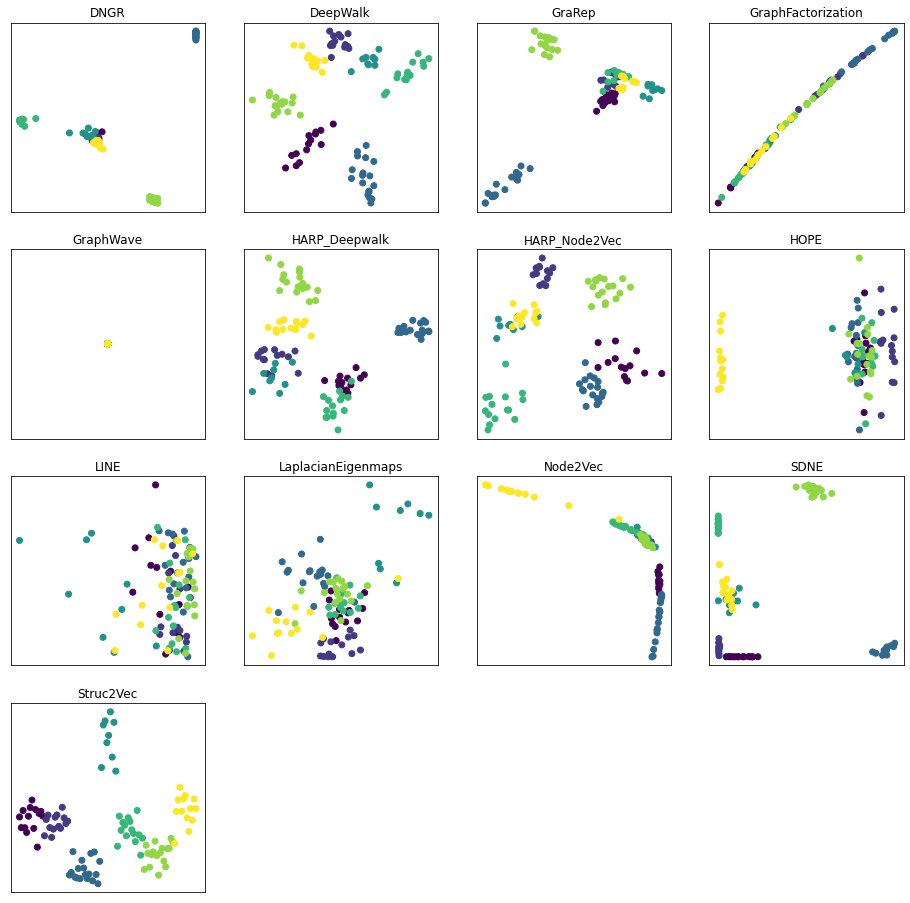

In [75]:
embeddings = (embeddings_d2[3], labels[3])
rcParams["figure.figsize"] = 16, 16
fig, axs = plt.subplots(4, 4)
names = list(embeddings[0].keys())
for i in range(len(names)):
    ix_x = i // 4
    ix_y = i % 4
    cur_Z = embeddings[0][names[i]]
    if cur_Z.shape[1] != 2:
        ss = StandardScaler().fit_transform(cur_Z)
        pca_Z = PCA(n_components=2).fit_transform(cur_Z)
        cur_Z = pca_Z
    axs[ix_x, ix_y].scatter(cur_Z[:, 0], cur_Z[:, 1], c=embeddings[1])
    axs[ix_x, ix_y].set_title(names[i])
    axs[ix_x, ix_y].set_xticks([])
    axs[ix_x, ix_y].set_yticks([])
while(i < 15):
    i += 1
    ix_x = i // 4
    ix_y = i % 4
    axs[ix_x, ix_y].set_xticks([])
    axs[ix_x, ix_y].set_yticks([])
    axs[ix_x, ix_y].axis('off')

In [11]:
rcParams["figure.figsize"] = 15, 18
fig, axs = plt.subplots(4, 4)
names = list(embeddings_d2.keys())
for i in range(len(names)):
    ix_x = i // 4
    ix_y = i % 4
    cur_Z = embeddings_d2[names[i]]
    if cur_Z.shape[1] != 2:
        ss = StandardScaler().fit_transform(cur_Z)
        pca_Z = PCA(n_components=2).fit_transform(cur_Z)
        cur_Z = pca_Z
    axs[ix_x, ix_y].scatter(cur_Z[:, 0], cur_Z[:, 1], c=labels)
    axs[ix_x, ix_y].set_title(names[i])

[{'DNGR': array([[9.95260239e-01, 9.87498224e-01, 9.64639783e-01, 9.85299706e-01,
          1.73538923e-04, 1.00000000e+00],
         [9.95057046e-01, 9.89060760e-01, 9.63513076e-01, 9.84628677e-01,
          1.58578157e-04, 1.00000000e+00],
         [9.94819641e-01, 9.88104582e-01, 9.58894014e-01, 9.83930588e-01,
          2.01106071e-04, 1.00000000e+00],
         [9.95742857e-01, 9.89703000e-01, 9.63314891e-01, 9.85052347e-01,
          2.15768814e-04, 1.00000000e+00],
         [9.94738340e-01, 9.87396955e-01, 9.66264904e-01, 9.85393941e-01,
          1.87873840e-04, 1.00000000e+00],
         [9.96364594e-01, 9.87395465e-01, 9.68439937e-01, 9.86004353e-01,
          1.72883272e-04, 1.00000000e+00],
         [9.94652390e-01, 9.85945225e-01, 9.57740426e-01, 9.83205318e-01,
          1.87426805e-04, 1.00000000e+00],
         [9.95439410e-01, 9.86619174e-01, 9.59313631e-01, 9.83277738e-01,
          1.62154436e-04, 1.00000000e+00],
         [9.95478809e-01, 9.89101470e-01, 9.60409880e-01

In [ ]:
results_dictionary = {}
for name, class_handle in get_embedding_methods_iterable():
    if not (name == "GCN" or name == "GNN"):
        if not (name == "HARP"):
            print("Currently processing " + str(name))
            results_dictionary[name] = class_handle.fast_embed(G, d=2)
            clear_output()
        else:
            print("Currently processing " + str(name) + ": Deepwalk")
            temp_name = "HARP_Deepwalk"
            results_dictionary[temp_name] = class_handle.fast_embed(G, d=2)
            print("Currently processing " + str(name) + ": Node2Vec")
            temp_name = "HARP_Node2Vec"
            results_dictionary[temp_name] = class_handle.fast_embed(G, d=2, method= "Node2Vec")
    